In [1]:
#!pip3 install -U -r version/version.txt

In [2]:
from herramientas.librerias import *
from qiskit.quantum_info import Statevector
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
%matplotlib inline
## Se configura la forma de visualizar los vectores con el uso latex y markdown
latex_formatter = get_ipython().display_formatter.formatters["text/latex"]
latex_formatter.for_type(np.ndarray, lambda m: to_ltx(m, print_out=False))

![imagen1](ADDER.png)

## Tomado del libro de Wolfgang Scherer

## Clase Quantum Adder: Q_Add

In [3]:
####Quantum Adder

from typing import List, Optional
import numpy as np

from qiskit.circuit import QuantumRegister

from qiskit.circuit.library.blueprintcircuit import BlueprintCircuit


class Q_add(BlueprintCircuit):
    
    Num_1=None#Numeros a sumar
    Num_2=None 
    in_string=''
    
    def __init__(self,
                 num_state_qubits: Optional[int] = None,
                 name: str = 'Q_adder') -> None:

        super().__init__(name=name)
        
        self._num_state_qubits = None
        self.num_state_qubits = num_state_qubits
        
        self._check_configuration      
        
    def print_name(self):
        print(self.name)  
  
        
    @property
    def num_state_qubits(self) -> int:
        """The number of qubits to be summed.
        Returns:
            The number of state qubits.
        """
        return self._num_state_qubits
    

    @num_state_qubits.setter
    def num_state_qubits(self, num_state_qubits: int) -> None:
        """Set the number of state qubits.
        Args:
            num_state_qubits: The new number of state qubits.
        """
        if self._num_state_qubits is None or num_state_qubits != self._num_state_qubits:
            self._invalidate()
            self._num_state_qubits = num_state_qubits
            self._reset_registers()
           

    def _reset_registers(self):
        if self.num_state_qubits:
            
            aux_1 = QuantumRegister((self.num_state_qubits+1),name= 'aux')
            num_a = QuantumRegister(self.num_state_qubits,name= 'numA')
            num_b = QuantumRegister((self.num_state_qubits),name= 'numB')
            
            self.qregs = [aux_1, num_a, num_b]
        else:
            self.qregs = []        
        

    def _check_configuration(self, raise_on_failure=True):
        valid = True
        if self._num_state_qubits is None:
            valid = False
            if raise_on_failure:
                raise AttributeError('Q_Add: The number of state qubits has not been set.')

    
    
    @property
    def in_string(self):
        
        Num_binary_a = '{0:b}'.format(int(self.Num_1))#[::-1]
        Num_binary_b = '{0:b}'.format(int(self.Num_2))#[::-1]

        if self.Num_1<self.Num_2:
            size=len(Num_binary_b)#número mayor
        else:
            size=len(Num_binary_a)

        aux_size=size+1

        Num_binary_a=Num_binary_a.rjust(size, '0')
        Num_binary_b=Num_binary_b.rjust(size, '0')

        Num_total=Num_binary_a[::-1]+Num_binary_b[::-1]

        Num_total=Num_total.rjust((size*2+aux_size), '0')##llena de ceros a la derecha, para los aux
        Num_total=Num_total[::-1]#self.in_string=Num_total[::-1]
        
        return Num_total        
               
    def _build(self):
        super()._build()
        ##Se crea una lista para construir el circuito ya que no se puede 
        ##acceder directamente a los registros: [ aux_1.... : num_a..... : num_b..... ]
        aux_1=self.qubits[:self.num_state_qubits+1]
        num_a=self.qubits[(self.num_state_qubits+1):(self.num_state_qubits*2+1)]
        num_b=self.qubits[(self.num_state_qubits*2+1):]

        U_c=QuantumCircuit(4,name="U_c")
        U_c.ccx(1,2,3) 
        U_c.cx(1,2)
        U_c.ccx(0,2,3) 
        
        U_c_dagg=QuantumCircuit(4,name="U_c*")
        U_c_dagg.ccx(0,2,3) 
        U_c_dagg.cx(1,2)
        U_c_dagg.ccx(1,2,3) 
        
        U_s=QuantumCircuit(3,name="U_s")
        U_s.cx(1,2)
        U_s.cx(0,2) 
        
        cont=1
       
        for i in range(0,(self.num_state_qubits)):
           
            self.append(U_c,[aux_1[cont-1],num_a[i],num_b[i],aux_1[cont]])           
            cont=cont+1

        self.barrier()

        self.cx(num_a[i],num_b[i])
        self.append(U_s,[aux_1[(self.num_state_qubits-1)],
                           num_a[self.num_state_qubits-1],
                           num_b[self.num_state_qubits-1]])  
        cont=(self.num_state_qubits*2-1-1)

        self.barrier()
        
        for i in range((self.num_state_qubits-2),-1,-1):
            self.append(U_c_dagg,[aux_1[i],num_a[i],num_b[i],aux_1[i+1]])
            self.append(U_s,[aux_1[i],num_a[i],num_b[i]])         

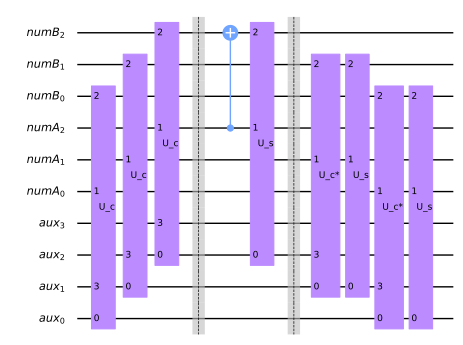

In [4]:
y=Q_add()
y.__init__(num_state_qubits=3, name = 'Q_adderAL')
y._build()
y.draw(output='mpl',scale=(0.7),reverse_bits='TRUE')

In [5]:
y.Num_1=5
y.Num_2=3

In [6]:
sv=y.in_string

In [7]:
print(sv)

0111010000


In [8]:
sv=y.in_string
print("Vector de entrada:",sv)
in_vector = Statevector.from_label(y.in_string)
out_vector=in_vector.evolve(y)
counts = out_vector.sample_counts(shots=1000)
print(y.Num_1,"+",y.Num_2,"=",(y.Num_1+y.Num_2))
print("Resultado:",counts)

Vector de entrada: 0111010000
5 + 3 = 8
Resultado: {'0001011000': 1000}


Orden de Salida: {$' sum_n <--> sum_o ...  numA_n <--> numA_o ...  aux_n <--> aux_o '$}  
en $ aux_n $ se guarda el carry

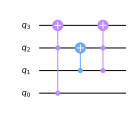

In [9]:
U_c_dagg=QuantumCircuit(4,name="U_c*")
U_c_dagg.ccx(0,2,3) 
U_c_dagg.cx(1,2)
U_c_dagg.ccx(1,2,3)
U_c_dagg.draw(output='mpl',scale=(0.5),reverse_bits='TRUE')

In [12]:
aux_1 = QuantumRegister(((y.num_qubits-1)/3+1),name= 'aux')
num_a = QuantumRegister(((y.num_qubits-1)/3),name= 'numA')
num_b = QuantumRegister(((y.num_qubits-1)/3),name= 'numB')
# medidas= ClassicalRegister(y.num_qubits,name= 'medidas')
sumador=QuantumCircuit(aux_1,num_a,num_b)#medidas <-- Se podría usar para ponerle nombre

In [13]:
sumador.draw(output='mpl',scale=(0.5),reverse_bits='TRUE')

binary_in=y.in_string[::-1]
for j, bit_a in enumerate(binary_in):  
        
    if bit_a=='1':
        sumador.x(j)
        

In [14]:
sumador.draw()

aux_0: ─────
             
 aux_1: ─────
             
 aux_2: ─────
             
 aux_3: ─────
        ┌───┐
numA_0: ┤ X ├
        └───┘
numA_1: ─────
        ┌───┐
numA_2: ┤ X ├
        ├───┤
numB_0: ┤ X ├
        ├───┤
numB_1: ┤ X ├
        └───┘
numB_2: ─────

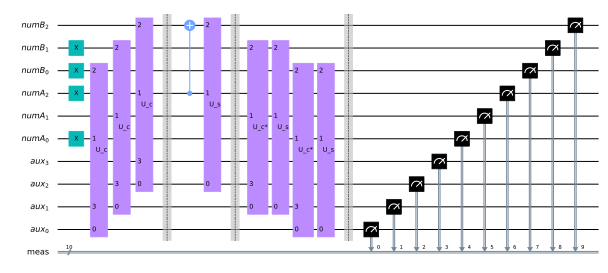

In [15]:
sum2=sumador+y
sum2.measure_all()
sum2.draw(output='mpl',scale=(0.5),reverse_bits='TRUE')